In [60]:
import cv2
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os

# Load xlsx file with labels
label_df = pd.read_excel('APS360_Project_Dataset/dataset5/labels.xlsx', dtype={'card_number': str})
label_df.columns = ['img_num', 'card_number']  

# Folder path for card images
image_1_folder = 'APS360_Project_Dataset/dataset5/img'

In [82]:
# Function to preprocess each card image and segment digits
def preprocess_and_segment_digits(image):
    # Convert to grayscale and apply binary threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold_value, binary_image = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours and filter based on contour size
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digit_contours = [cnt for cnt in contours if cv2.boundingRect(cnt)[2] > 4]  # Filter out small contours, only keep contours with width > # pixels
    
    # Sort contours from left to right
    digit_contours = sorted(digit_contours, key=lambda x: cv2.boundingRect(x)[0])
    
    # Segment each digit
    digit_images = []
    for cnt in digit_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        digit_image = binary_image[y:y+h, x:x+w]
        digit_image = cv2.resize(digit_image, (32, 32))  # Resize to a standard size
        digit_images.append(digit_image)

    return digit_images  # Each element in digit_images is a 32x32 binary image (np array) containing a single digit

# Function to extract HOG features from a list of digit images
def extract_hog_features(images):
    hog_features = []
    for img in images:
        feature = hog(img, orientations=16, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)


In [80]:
# Load ResNet18 pre-trained model as a feature extractor
resnet_model = resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet_model.children())[:-1])  # Remove the last fully connected layer
feature_extractor.eval()  # Set to evaluation mode

# Move feature extractor to the appropriate device (MPS or CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
feature_extractor = feature_extractor.to(device)

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])


In [83]:
# Initialize lists to store full card number sequences and digit-level data
y_true_sequences = []       # True sequences (full card numbers)
y_pred_sequences = []       # Predicted sequences (full card numbers, populated after prediction)
all_digit_pred = []         # Predicted digit images (individual digits)
all_digit_labels = []       # True digit labels (individual digits)

# Loop through each image and label in the dataset
for index, row in label_df.iterrows():
    # Check for missing card number and skip if missing
    card_number = str(int(row['card_number'])) if pd.notna(row['card_number']) else None
    if card_number is None:
        print(f"Warning: Skipped row {index} due to missing card number.")
        continue
    
    # Convert card_number to a string with only digits (removes any non-numeric characters)
    card_number = ''.join(filter(str.isdigit, card_number))
    y_true_sequences.append(card_number)  # Add to true sequence list

    # Read and preprocess the image
    image_path = os.path.join(image_1_folder, f"{row['img_num']}.jpg")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue

    # Preprocess image and segment digits
    digit_images = preprocess_and_segment_digits(image)
    
    # Allow partial matching if segmentation count doesn't match expected length
    min_length = min(len(digit_images), len(card_number))

    if min_length > 0:
        predicted_sequence = []
        
        for i in range(min_length):
            digit_img = digit_images[i]
            predicted_sequence.append(digit_img)         # Store each segmented digit image

            all_digit_pred.append(digit_img)           # Keep for digit-level analysis
            all_digit_labels.append(int(card_number[i])) # Corresponding true label

        # # Form the predicted sequence from available segmented digits
        label_of_predicted_digits_length = ''.join([str(int(card_number[i])) for i in range(min_length)])
        y_pred_sequences.append(label_of_predicted_digits_length)

        print(f"Processed card number {row['img_num']}: True Label= {card_number}, Label of predicted digits length = {label_of_predicted_digits_length}")

    else:
        print(f"Warning: No valid segments for {image_path}, skipped.")


Processed card number 1: True Label= 625156888888888, Label of predicted digits length = 625156888888888
Processed card number 2: True Label= 6227000411010422600, Label of predicted digits length = 6
Processed card number 3: True Label= 9559980210373015416, Label of predicted digits length = 9
Processed card number 4: True Label= 6228484150498182715, Label of predicted digits length = 6228484150498182715
Processed card number 5: True Label= 9559980095637130717, Label of predicted digits length = 9
Processed card number 6: True Label= 6212842930330021010, Label of predicted digits length = 6212842930330021010
Processed card number 7: True Label= 6217002990100619141, Label of predicted digits length = 6217002990100619141
Processed card number 8: True Label= 8888888888888888, Label of predicted digits length = 8888888888888888
Processed card number 9: True Label= 6222802212011989816, Label of predicted digits length = 62228022120119898
Processed card number 10: True Label= 621985610000599

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


Processed card number 171: True Label= 4270388888888888, Label of predicted digits length = 4270388888888888
Processed card number 172: True Label= 62215503, Label of predicted digits length = 6
Processed card number 173: True Label= 4047398888888888, Label of predicted digits length = 4047398888888888
Processed card number 174: True Label= 6228368888888888, Label of predicted digits length = 6228368888888888
Processed card number 175: True Label= 6228108888888888, Label of predicted digits length = 6228108888888888
Processed card number 176: True Label= 4580718888888888, Label of predicted digits length = 4580718888888888
Processed card number 177: True Label= 6228688888888888, Label of predicted digits length = 6228688888888888
Processed card number 178: True Label= 5212990088888888, Label of predicted digits length = 5
Processed card number 179: True Label= 6222528888888888, Label of predicted digits length = 6222528888888888
Processed card number 180: True Label= 5218990088888888, 

In [84]:
# X contains HOG features for each digit image, y contains the true labels (digits)
X = extract_hog_features(all_digit_pred)  # HOG features
y = np.array(all_digit_labels)            # True digit labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [85]:
# Define the parameter distribution
param_dist = {
    'C': stats.uniform(0.1, 100),         # Randomly samples C values from 0.1 to 100
    'kernel': ['linear', 'rbf', 'poly'],  # Choose between linear, RBF, and polynomial kernels
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]  # Options for gamma
}

# Initialize the SVM model
svm_model = SVC()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, cv=5, n_iter=50, scoring='accuracy', verbose=2, n_jobs=-1, random_state=78)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Retrieve the best parameters and best model
best_params = random_search.best_params_
best_svm_model = random_search.best_estimator_
# Train the model on the training data
svm_model.fit(X_train, y_train)
train_accuracy = svm_model.score(X_train, y_train)

# Optionally, evaluate the model on the test set to check accuracy
test_accuracy = svm_model.score(X_test, y_test)
print(f"SVM Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"SVM Test Accuracy: {test_accuracy * 100:.2f}%")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=  37.7s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=  37.9s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=  37.7s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=  38.0s
[CV] END .......C=4.918122750023768, gamma=scale, kernel=rbf; total time=  38.0s
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time= 1.0min
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time= 1.0min
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time= 1.0min
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time=  57.7s
[CV] END .......C=59.758200889906725, gamma=1, kernel=linear; total time=  59.3s
[CV] END ......C=24.75676348772128, gamma=0.1, kernel=linear; total time=  41.1s
[CV] END .....C=76.16209251584098, gamma=0.01, 

Test Accuracy: 39.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.15      0.23       174
           1       1.00      0.07      0.13       101
           2       0.43      0.14      0.21       189
           3       0.00      0.00      0.00        58
           4       1.00      0.03      0.07        58
           5       0.60      0.04      0.07        81
           6       0.50      0.39      0.44       145
           7       0.50      0.01      0.02        79
           8       0.37      0.96      0.54       437
           9       1.00      0.04      0.08        51

    accuracy                           0.40      1373
   macro avg       0.59      0.18      0.18      1373
weighted avg       0.51      0.40      0.30      1373



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


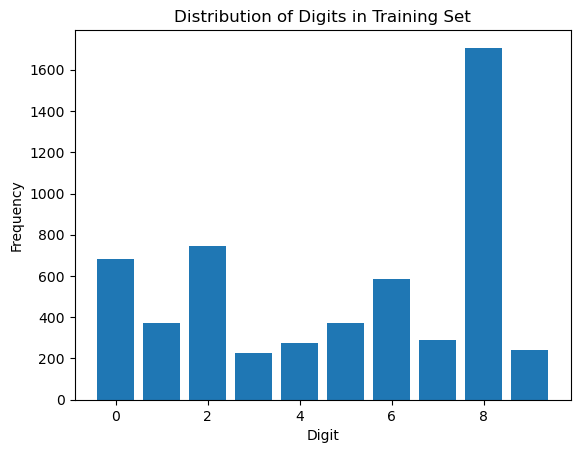

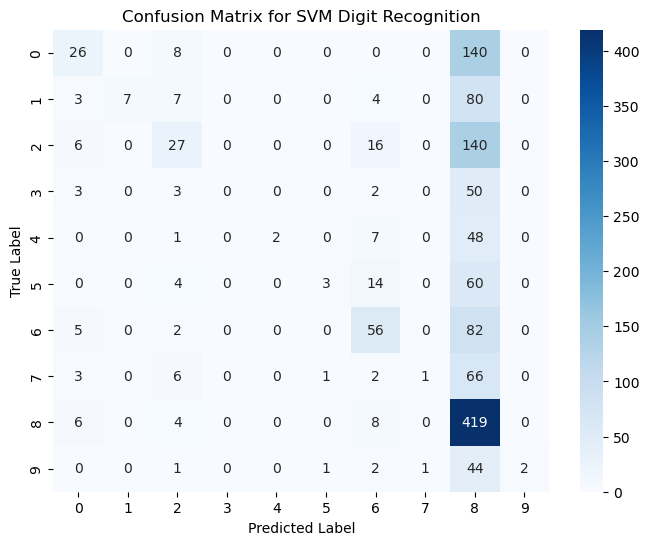

In [86]:
# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate digit-level accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


# Print a detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.title("Distribution of Digits in Training Set")
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVM Digit Recognition")
plt.show()


In [38]:
# Function to predict a full card number sequence
def predict_card_number(digit_images, knn_model):
    predicted_digits = []
    
    for digit_img in digit_images:
        # Extract HOG features for the digit image
        hog_feature = extract_hog_features([digit_img])[0]  # Get the first element since it's a single image

        # Use KNN model to predict the digit
        predicted_digit = knn_model.predict([hog_feature])[0]  # Predict and get the digit label
        predicted_digits.append(str(predicted_digit))

    # Combine all predicted digits to form the card number
    predicted_card_number = ''.join(predicted_digits)
    return predicted_card_number

# Initialize lists to store true and predicted card number sequences
true_card_numbers = []
predicted_card_numbers = []

# Load xlsx file with labels
label_df = pd.read_excel('APS360_Project_Dataset/dataset5/labels.xlsx', dtype={'card_number': str})
label_df.columns = ['img_num', 'card_number']  

# Folder path for card images
image_1_folder = 'APS360_Project_Dataset/dataset5/img'

# Loop through each image and label in the dataset
for index, row in label_df.iterrows():
    # Read the image
    image_path = os.path.join(image_1_folder, f"{row['img_num']}.jpg")
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image at {image_path}")
        continue

    # Check for missing card number and skip if missing
    true_card_number = str(int(row['card_number'])) if pd.notna(row['card_number']) else None
    if true_card_number is None:
        print(f"Warning: Skipped row {index} due to missing card number.")
        continue
    # Convert card_number to a string with only digits (removes any non-numeric characters)
    true_card_number = ''.join(filter(str.isdigit, true_card_number))
    true_card_numbers.append(true_card_number)  # Add to true sequence list

    # Preprocess and segment digits from the image
    digit_images = preprocess_and_segment_digits(image)

    # Predict each digit in the segmented images
    predicted_digits = []
    for digit_img in digit_images:
        # Extract HOG features for the digit
        hog_feature = extract_hog_features([digit_img])[0]  # Extract feature and get the single array element
        # Predict the digit using the KNN model
        predicted_digit = svm_model.predict([hog_feature])[0]
        predicted_digits.append(str(predicted_digit))  # Store as a string for joining later

    # Combine predicted digits to form the full card number
    predicted_card_number = ''.join(predicted_digits)
    predicted_card_numbers.append(predicted_card_number)

    print(f"True Card Number: {true_card_number}, Predicted Card Number: {predicted_card_number}")

True Card Number: 625156888888888, Predicted Card Number: 8088882888888888888888888888888888888888288888888882882888888888288
True Card Number: 6227000411010422600, Predicted Card Number: 6
True Card Number: 9559980210373015416, Predicted Card Number: 6
True Card Number: 6228484150498182715, Predicted Card Number: 28888888888888888888888888888888
True Card Number: 9559980095637130717, Predicted Card Number: 6
True Card Number: 6212842930330021010, Predicted Card Number: 86886888888888888888888888888888888888888888888828286888888888888888888888888888888888888888888888888808888868888
True Card Number: 6217002990100619141, Predicted Card Number: 8886888888682868828888888888888888888888888888888888888888888886888888888088888888888888888888888888888888888888888888888888888888888888888888888888888888882888888888288882888888888888888888888888882888888882288088888888888888888888888888888828888828888888882888888888888888688888888688828888888888882888888888286888888888886888888888888888888888888

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


True Card Number: 5398710042970205, Predicted Card Number: 88828888888888888888888
True Card Number: 4556449026663004, Predicted Card Number: 8888888888888888888888888888868888888888
True Card Number: 4840251126590, Predicted Card Number: 6888888888888828888888888888888888
True Card Number: 373700324324007, Predicted Card Number: 888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888288888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888880888888888888888888888888888888888888888888888888
True Card Number: 373700324321003, Predicted Card Number: 8
True Card Number: 1387454

In [39]:

# Calculate accuracy of full card number predictions
correct_sequences = sum(1 for true, pred in zip(true_card_numbers, predicted_card_numbers) if true == pred)
sequence_accuracy = correct_sequences / len(true_card_numbers) * 100
print(f"Full Card Number Prediction Accuracy: {sequence_accuracy:.2f}%")

# Optional: Detailed evaluation of digit-level predictions
y_true_digits = [int(digit) for card in true_card_numbers for digit in card]
y_pred_digits = [int(digit) for card in predicted_card_numbers for digit in card]

print("Digit-Level Classification Report:\n", classification_report(y_true_digits, y_pred_digits))

# Plot confusion matrix for digit-level predictions
conf_matrix = confusion_matrix(y_true_digits, y_pred_digits)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for KNN Digit Recognition")
plt.show()

Full Card Number Prediction Accuracy: 0.00%


ValueError: Found input variables with inconsistent numbers of samples: [10290, 27332]